In [123]:
# Run this code to unzip the Skin Diseases Data into a "dataset" folder
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('dataset')
files.close()

In [362]:
# Useful Imports

# Torch Imports
import torch 
import torch.nn as nn
import torch.utils.data as data

# Torchvision Imports
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Utility Imports
import matplotlib.pyplot as plt
import numpy as np

# Metric and Matrix Imports
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score

# Bayesian Optimization Imports
import GPyOpt

In [363]:
# Converts every image to 256x256 dimension, randomly change images for generalization,
# into a tensor, normalize pixel values
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Converts every image to 256x256 dimension and into a Tensor
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=val_test_transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=val_test_transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [364]:
# Total images in each subset
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(val_dataset))

Train data:  1198
Test data:  389
Valid data:  250


torch.Size([3, 128, 128])
tensor(0)
torch.Size([25, 3, 128, 128])
torch.Size([25])


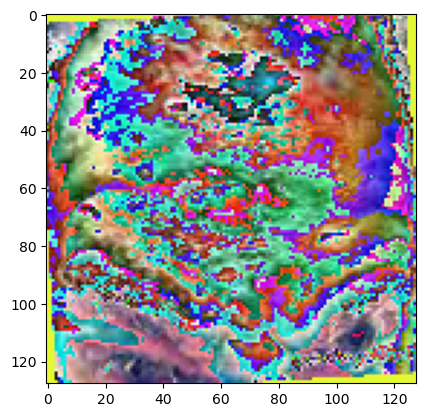

In [365]:
# Check a batch of data
images, labels = next(iter(train_dataloader))

print(images[0].size()) # Number of Colors (RGB=3), Height=256, Width=256
print(labels[0]) # Herpes=0, Melanoma=1, Monkeypox=2, Sarampion=3, Varicela=4
print(images.shape)
print(labels.shape)

# Will show the image sampled
image = transforms.ToPILImage()(images[0])
plt.imshow(image)
plt.show()

In [366]:
# Calculates output layer size, convenient when making multiple hidden layers
def output_size(in_channels, kernel_size, padding, stride, pool):
    return np.floor((((in_channels - kernel_size + (2 * padding)) / stride) + 1) / pool)

# Test Run of output_size
output_shape = output_size(128, 3, 0, 1, 2)
print(output_shape)

63.0


In [367]:
# Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self, dropout, kernel, channels):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(128, kernel, 0, 1, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(channels*2, channels*4, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(channels*4, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2))

        output_shape = output_size(output_shape, kernel, 0, 1, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(channels*2, channels, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2))

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(channels*int(output_shape)*int(output_shape), channels*2),
            nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(channels*2, channels),
            nn.ReLU())
        
        self.fc3 = nn.Linear(channels, 5)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [368]:
# Allows model to run on GPU if it is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [369]:
# Test run, should output torch.Size([batch_size, classes])
custom_cnn = CustomCNN(dropout=0.3, kernel=3, channels=32).to(device)
output = custom_cnn(images.to(device))
print(output.size())

torch.Size([25, 5])


In [370]:
# Define a train_model function
def train_model(model, criterion, optimizer, epochs):
    total_step = len(train_dataloader)
    
    for epoch in range(epochs):
        loss_per_epoch = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_per_epoch += loss.item()
            #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    #.format(epoch+1, epochs, i+1, total_step, loss.item()))
        print(f"Epoch: {epoch+1}, {loss_per_epoch/total_step}")

In [371]:
# Declare Custom CNN Model
custom_cnn = CustomCNN(dropout=0.1, kernel=3, channels=32).to(device)

# Set Hyper Parameters
epochs = 50
learning_rate = 0.0001

# Declare Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

In [ ]:
# Train Custom CNN Model
train_model(custom_cnn, criterion, optimizer, epochs)

Epoch: 1, 0.3049982519975553
Epoch: 2, 0.27198821663235623
Epoch: 3, 0.22206759514907995
Epoch: 4, 0.19615173052685955
Epoch: 5, 0.1662760543016096
Epoch: 6, 0.1961400432822605
Epoch: 7, 0.1616403586231172
Epoch: 8, 0.18485990011443695
Epoch: 9, 0.17146645307851335
Epoch: 10, 0.1496743579239895
Epoch: 11, 0.14502784757254025
Epoch: 12, 0.09539407033783694
Epoch: 13, 0.10309345248000075
Epoch: 14, 0.10490117505347978
Epoch: 15, 0.13495991906772056
Epoch: 16, 0.1451869533242037
Epoch: 17, 0.13755317765753716
Epoch: 18, 0.0968158806305534
Epoch: 19, 0.0933827550325077
Epoch: 20, 0.08133231464307755
Epoch: 21, 0.07895596364202599
Epoch: 22, 0.08671362422561894
Epoch: 23, 0.08330847508235213
Epoch: 24, 0.08907740788223843
Epoch: 25, 0.07395047104607026
Epoch: 26, 0.06238622392023293
Epoch: 27, 0.11433405687178795
Epoch: 28, 0.08899818702290456
Epoch: 29, 0.06531343457754701
Epoch: 30, 0.05655330665952837
Epoch: 31, 0.07842850163190936
Epoch: 32, 0.10964320784357066
Epoch: 33, 0.109360189642

In [373]:
# Define a calculate_accuracy function
def calculate_accuracy(model, dataloader, device):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [374]:
# Produces a confusion matrix, and metrics including Precision, Recall, and F1 Score
def confusion_matrix_and_metrics(model, dataloader, device):
    model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=dataloader.dataset.classes, 
        yticklabels=dataloader.dataset.classes)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Precision of the MLP :\t"+str(precision_score(y_true, y_pred, average="macro")))
    print("Recall of the MLP    :\t"+str(recall_score(y_true, y_pred, average="macro")))
    print("F1 Score of the Model :\t"+str(f1_score(y_true, y_pred, average="macro")))

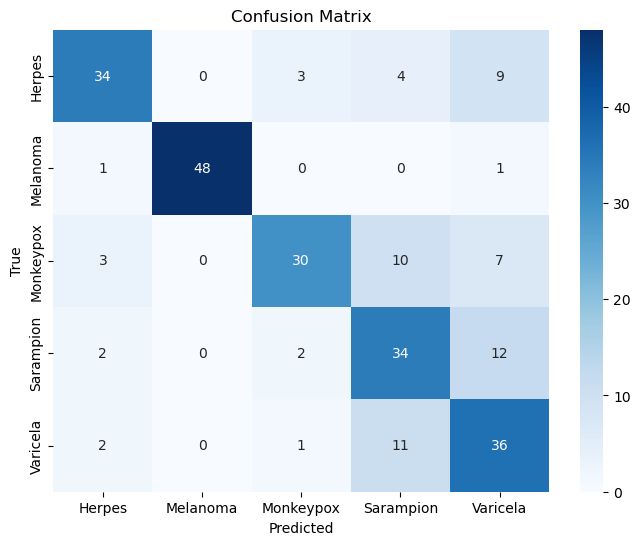

Precision of the MLP :	0.7545948966287949
Recall of the MLP    :	0.7280000000000001
F1 Score of the Model :	0.7332673715305734
Accuracy: 72.8%


In [375]:
# Calculate Custom CNN Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(custom_cnn, val_dataloader, device)
calculate_accuracy(custom_cnn, val_dataloader, device)

In [94]:
# Implementation of Bayesian Optimization to improve Hyper Parameters

# Representation of how our model is changed
def objective(params):
    
    learning_rate = params[0][0]
    batch_size = int(params[0][1])
    dropout = params[0][2]
    kernel = int(params[0][3])
    channels = int(params[0][4])
    
    custom_cnn = CustomCNN(dropout, kernel, channels).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
    val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

    custom_cnn.train()
    for epoch in range(20):
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = custom_cnn(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    custom_cnn.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = custom_cnn(images)
            _, predicted = torch.max(outputs, 1)
    
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    print(-accuracy)
    return -accuracy

In [95]:
# Range of tested values in Bayesian Optimization
domain = [
    {"name": "learning_rate", "type": "continuous", "domain": (1e-5, 1e-2)},
    {"name": "batch_size", "type": "discrete", "domain": [25, 50, 100, 200]},
    {"name": "dropout", "type": "continuous", "domain": (0.1, 0.7)},
    {"name": "kernel", "type": "discrete", "domain": [3, 5, 7]},
    {"name": "channels", "type": "discrete", "domain": [8, 16, 32, 64, 128]}
]

# Run Bayesian Optimization
opt = GPyOpt.methods.BayesianOptimization(f=objective, domain=domain)
opt.run_optimization(max_iter=10)

0.2
0.388
0.316
0.208
0.376
0.416
0.404
0.288
0.604
0.512


In [96]:
# Print Results
best_params = opt.X[np.argmin(opt.Y)]
param_names = ["Learning Rate", "Batch Size", "Dropout", "Kernel Size", "Channels"]

print("Best Hyper Parameters: ")
for param_name, best_param in zip(param_names, best_params):
    if param_name == "Learning Rate" or param_name == "Dropout":
        print(f'{param_name}: {float(best_param)}')
    else:
        print(f'{param_name}: {int(best_param)}')
print(f'Loss: {-np.min(opt.Y)}')

Best Hyper Parameters: 
Learning Rate: 1e-05
Batch Size: 25
Dropout: 0.1
Kernel Size: 3
Channels: 32
Loss: 0.604


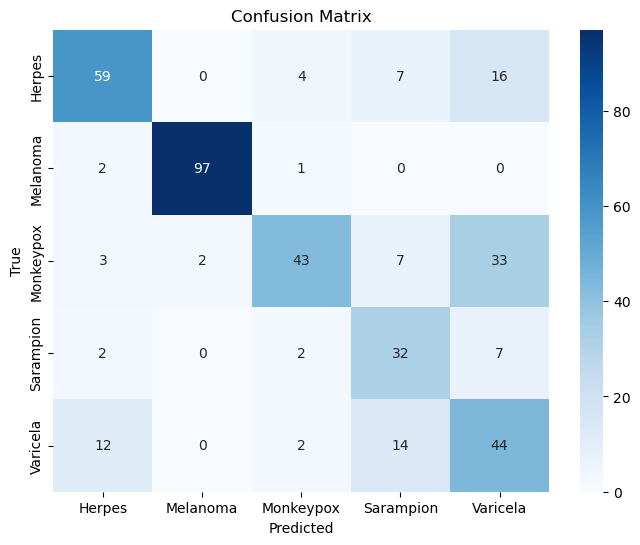

Precision of the MLP :	0.7072929292929293
Recall of the MLP    :	0.699996006577402
F1 Score of the Model :	0.6883318823089354
Accuracy: 70.69408740359897%


In [376]:
# Test Custom CNN Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(custom_cnn, test_dataloader, device)
calculate_accuracy(custom_cnn, test_dataloader, device)

In [342]:
# Data organization for ResNet Models
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [345]:
# Declare ResNet50 Model
#weights=torchvision.models.ResNet50_Weights.DEFAULT
resnet_50 = torchvision.models.resnet50(pretrained=True)

for param in resnet_50.parameters():
    param.requires_grad = False
        
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 5)
resnet_50 = resnet_50.to(device)

In [346]:
epochs = 50
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = learning_rate)

In [347]:
train_model(resnet_50, criterion, optimizer, epochs)

Epoch: 1, 1.5186908195416133
Epoch: 2, 1.2781564618150394
Epoch: 3, 1.1358900343378384
Epoch: 4, 1.0256024152040482
Epoch: 5, 0.9473322580258051
Epoch: 6, 0.8868681651850542
Epoch: 7, 0.8296249931057295
Epoch: 8, 0.7943891882896423
Epoch: 9, 0.75139012063543
Epoch: 10, 0.7130016510685285
Epoch: 11, 0.7210055210938057
Epoch: 12, 0.6779719721525908
Epoch: 13, 0.6556468512862921
Epoch: 14, 0.6300686455021302
Epoch: 15, 0.6113711421688398
Epoch: 16, 0.6102323470016321
Epoch: 17, 0.5888421398897966
Epoch: 18, 0.5652309240152439
Epoch: 19, 0.5594896394759417
Epoch: 20, 0.5556787494570017
Epoch: 21, 0.551000285272797
Epoch: 22, 0.5366938896477222
Epoch: 23, 0.531295781955123
Epoch: 24, 0.5159818610797325
Epoch: 25, 0.5087719839066267
Epoch: 26, 0.5117757438371578
Epoch: 27, 0.49721646433075267
Epoch: 28, 0.4902275713781516
Epoch: 29, 0.4867839114740491
Epoch: 30, 0.4819384943693876
Epoch: 31, 0.47722115988532704
Epoch: 32, 0.48495866172015667
Epoch: 33, 0.45929492140809697
Epoch: 34, 0.457017

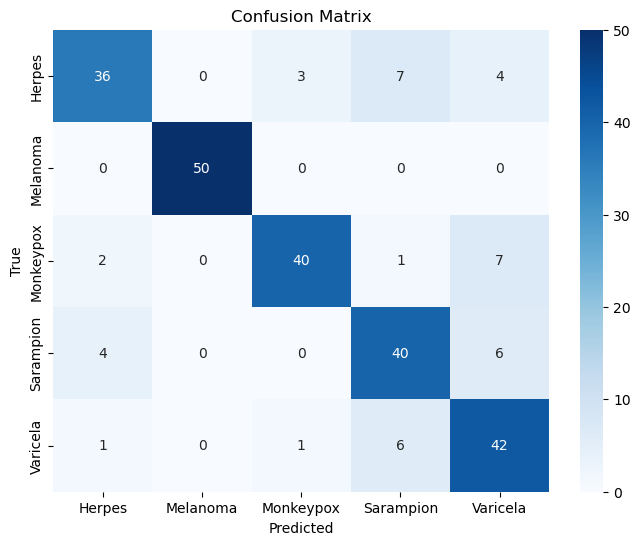

Precision of the MLP :	0.8397810717873785
Recall of the MLP    :	0.8320000000000001
F1 Score of the Model :	0.8330260698479925
Accuracy: 83.2%


In [348]:
# Caculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(resnet_50, val_dataloader, device)
calculate_accuracy(resnet_50, val_dataloader, device)

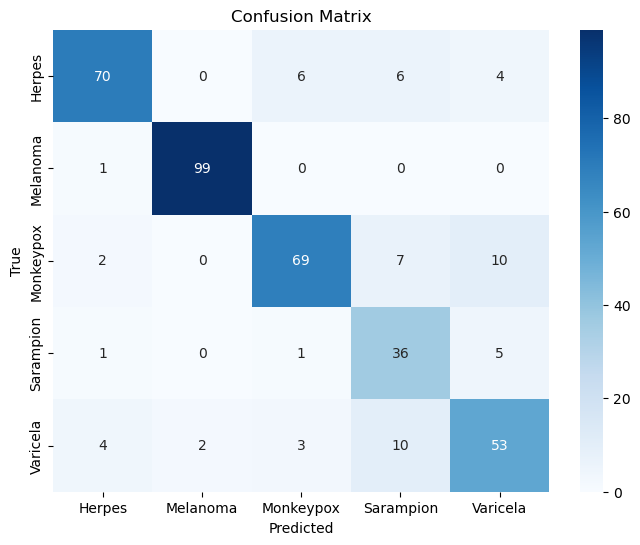

Precision of the MLP :	0.8194664482786799
Recall of the MLP    :	0.832272962179939
F1 Score of the Model :	0.8214147865785094
Accuracy: 84.06169665809769%


In [349]:
# Caculate Test Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(resnet_50, test_dataloader, device)
calculate_accuracy(resnet_50, test_dataloader, device)

In [ ]:
# from torch.utils.data.sampler import SubsetRandomSampler
# # Data organization for AlexNet model
# # https://www.digitalocean.com/community/tutorials/alexnet-pytorch
# def get_train_valid_loader(batch_size=25, augment=False, random_seed=1, shuffle=True, num_workers=3):
#     normalize = transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     )

#     # define transforms
#     valid_transform = transforms.Compose([
#             transforms.Resize((227,227)),
#             transforms.ToTensor(),
#             normalize,
#     ])
#     if augment:
#         train_transform = transforms.Compose([
#             transforms.RandomCrop(32, padding=4),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ])
#     else:
#         train_transform = transforms.Compose([
#             transforms.Resize((227,227)),
#             transforms.ToTensor(),
#             normalize,
#         ])

#     # load the dataset
#     train_dataset = datasets.ImageFolder(root='dataset/Train', transform=train_transform)
#     valid_dataset = datasets.ImageFolder(root='dataset/Test', transform=valid_transform)

#     num_train = len(train_dataset)
#     indices = list(range(num_train))
#     if shuffle:
#         np.random.seed(random_seed)
#         np.random.shuffle(indices)
#     train_sampler = SubsetRandomSampler(indices)

#     train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
#     valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#     return (train_loader, valid_loader)


# def get_test_loader(batch_size=25, num_workers=3):
#     normalize = transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     )

#     # define transform
#     transform = transforms.Compose([
#         transforms.Resize((227,227)),
#         transforms.ToTensor(),
#         normalize,
#     ])

#     test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)

#     test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#     return test_dataloader

In [ ]:
# train_loader, valid_loader = get_train_valid_loader()
# test_loader = get_test_loader()

In [ ]:
# Data organization for AlexNet model
# do we need consistent shuffle across different models? (will it affect model evaluation?)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
# Declare AlexNet model
# https://analyticsindiamag.com/ai-mysteries/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()

# Update classifiers of model
alexnet.classifier[4] = nn.Linear(4096,1024) # update second classifier of model to reduce number of nodes in dense layers of network
alexnet.classifier[6] = nn.Linear(1024,5) # update output layer of network to have 5 class labels
alexnet.eval()

In [ ]:
alexnet = alexnet.to(device)

In [ ]:
epochs = 50
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
alexnet_optimizer = torch.optim.SGD(alexnet.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
train_model(alexnet, criterion, alexnet_optimizer, epochs)

In [ ]:
# Calculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(alexnet, val_dataloader, device)
calculate_accuracy(alexnet, val_dataloader, device)

In [ ]:
# Calculate Test Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(alexnet, test_dataloader, device)
calculate_accuracy(alexnet, test_dataloader, device)